In [1]:
# Change the directory form the notebook
%cd ..

/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Humsa/HumsaTraces


# Humsa project - Calcium release / Synchronicity

In [2]:
# load all the necessary modules for the analysis
from cellsync.io import *
from cellsync.registration import *
from cellsync.segmentation import *
from cellsync.correlation import *
from cellsync.plot_traces import *
from cellsync.synchronicity import *
from cellsync.to_dataframe import *

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Plot inside the notebook
%matplotlib inline
# this is used for debugging purposes only. allows to reload classes when changed
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt

In [6]:
# General parameters of the plot
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# Opening the file

In [7]:
%cd ..

/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Humsa


In [8]:
# Define the data directory

path = 'TSeries-04032018-1326-slicenewpatch-035_nbqx122_ap5200_to_analayze/'

In [9]:
# The function metadata will generate a Python dictionaty with some important information
meta = metadata(path)

In [10]:
for key in meta:
    print(key)

sizeT
sizeX
sizeY
dtype
shapeX
shapeY
TimePoint


In [11]:
# open_file will open the file as a numpy stack.
# File should be in subfolder/_channel_1 or 

ch1 = open_file(path, meta, ch="/channel_1")
ch2 = open_file(path, meta, ch="/channel_2")

# Introduction to Numpy

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Note that, although, some 3D images are constructed with equal resolution in each dimension. In microscopy, data captured in the Z dimension have (usually) lower resolution than in XY. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.


In [12]:
print("ch1 shape:", ch1.shape)
print("type:", ch1.dtype)
print("Size in bytes:", ch1.nbytes)

ch1 shape: (3000, 322, 366)
type: uint16
Size in bytes: 707112000


In [13]:
#It is possible to select only the first 1000 frames:
ch1 = ch1[0:1000]
ch2 = ch2[0:1000]
#However, it's important to adjust the metadata
meta['TimePoint'] = meta['TimePoint'][0:1000]
meta['sizeT'] = len(meta['TimePoint'])

# Visualization of the data

In [14]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [15]:
@interact(img = fixed(ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=499, description='x', max=999), Output()), _dom_classes=('widget-interac…

# Motion correction
First we create a motion correction object (shift) by using phase correlation to identify the relative shift between two similar-sized images.

In [16]:
shifts = list_shift(ch1)

We can plot the result:

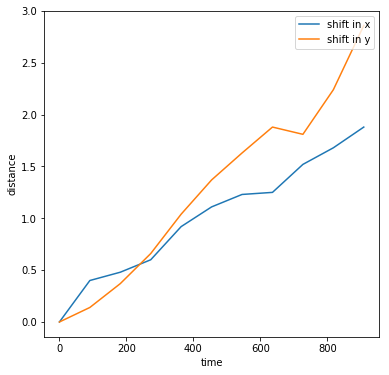

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
x_range = np.arange(0, ch1.shape[0], ch1.shape[0]/len(shifts))
ax.plot(x_range, shifts[:,0], label='shift in x')
ax.plot(x_range, shifts[:,1], label='shift in y')
ax.legend(loc='upper right')
ax.set_ylabel('distance')
ax.set_xlabel('time')

### Using the measured shift, we can now perform motion correction.

In [18]:
reg_ch1 = registration(ch1, shifts)

Cell bellow can be use to inspect in detail the result


from scipy import stats
list_idxs = range(0,len(ch1))
r = []
r1 = []
for idxs in list_idxs:
    try:
        r.append(stats.pearsonr(np.ravel(ch1[idxs]), np.ravel(ch1[idxs+1]))[0])
        r1.append(stats.pearsonr(np.ravel(reg_ch1[idxs]), np.ravel(reg_ch1[idxs+1]))[0])
    except IndexError:
        break

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
#x_range = np.arange(0, ch1.shape[0], ch1.shape[0]/len(shifts))
ax.plot(r, label='before')
ax.plot(r1, label='after')
ax.legend(loc='upper right')
ax.set_ylabel('distance')
ax.set_xlabel('time')

Alternatively we can "visually" inspect the result

In [19]:
@interact(img = fixed(reg_ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(reg_ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=499, description='x', max=999), Output()), _dom_classes=('widget-interac…

# Segmentation using SLIC (Simple Linear Iterative Clustering), a K-Means based image segmentation.
[Achanta et al. 2012](https://ieeexplore.ieee.org/document/6205760/)

In [20]:
seg, im_reg = slic_segment(reg_ch1, strength=300)

Explore the segmentation result:

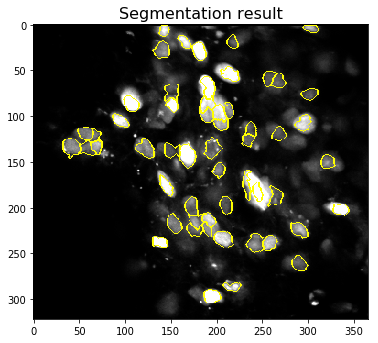

In [21]:
from skimage import exposure, segmentation
p2, p98 = np.percentile(im_reg.astype(np.int16), (2, 98))
new_eq = exposure.rescale_intensity(im_reg.astype(np.int16), in_range=(p2, p98))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation.mark_boundaries(new_eq, seg))
ax.set_title('Segmentation result', fontsize=16)

### Registration channel2 (Ca) using the registration object calculated on ch1

In [22]:
ch2_reg = registration(ch2, shifts)

# Create correlation image
The correlation image for each pixel is computed by averaging the correlation coefficients (taken over time) of each pixel with its four immediate neighbors. Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3)

In [23]:
ch2_corr = correlations(ch2_reg)

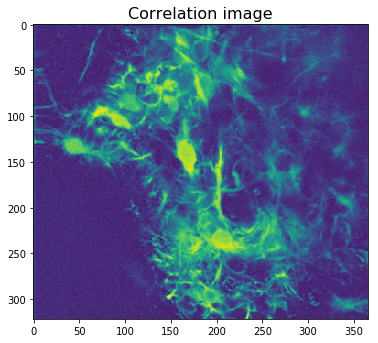

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(ch2_corr)
ax.set_title('Correlation image', fontsize=16)

# Extract ${\Delta F}/F$ fluorescence trace
Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3)

In [25]:
d, data, cell_position, labels, regions_ch2 = create_traces(ch2_reg,seg)

# Plot traces
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_traces'

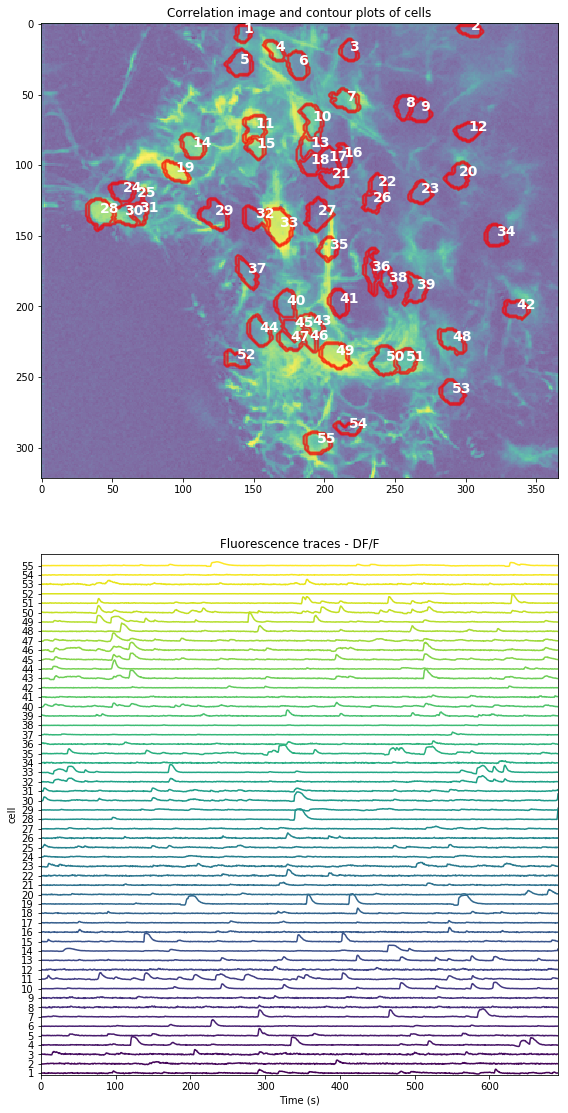

In [26]:
plot_traces(ch2_corr, meta, data, seg, cell_position, labels, save=False)

# Find synchronization and plot
Local maxima of calcium signals were detected by the [detect_peaks](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb) function writtend by Marcos Duarte.

The synchronicity S, which was defined by [Osswald et al. 2015](https://www.nature.com/articles/nature16071) as
the fraction of the whole number of synchronous cells (NSyn) divided by the number of calcium peaks for the given cell (NCa). In case the cells were not active, a synchronicity of zero was allotted. 
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_correlation'

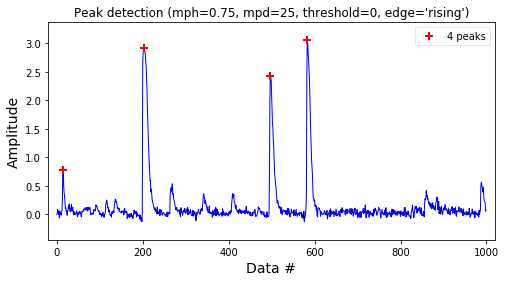

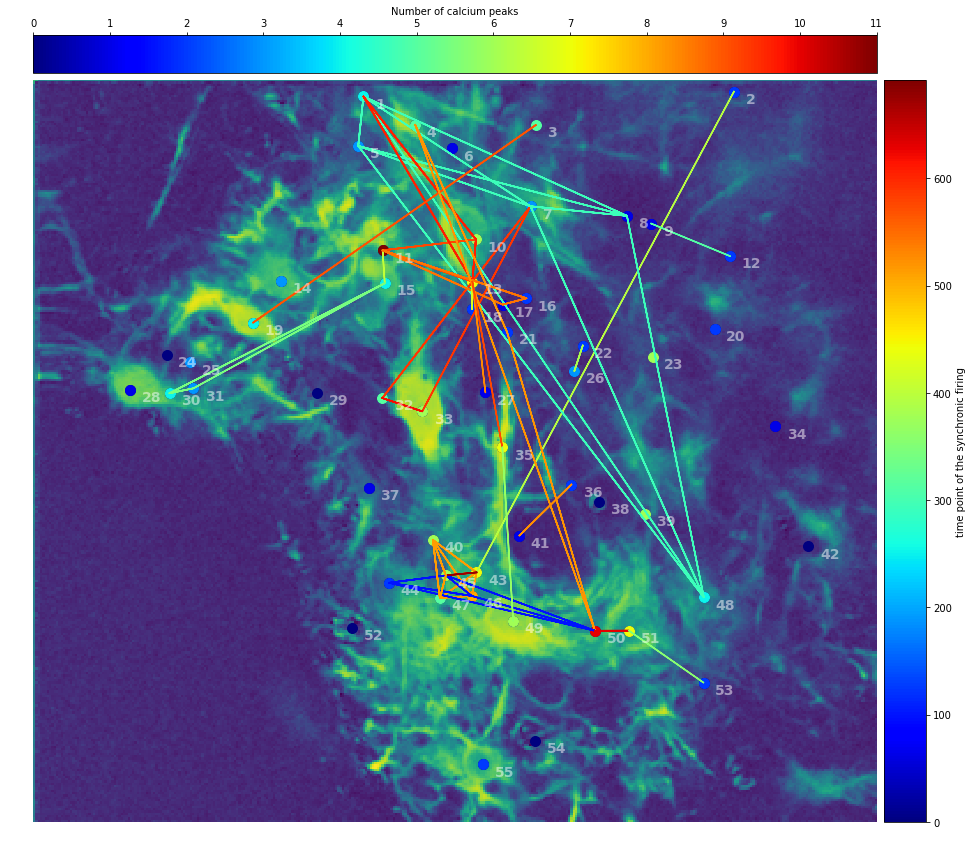

In [27]:
# sync_time is the window used around each peak to calculate synchronicity.
# Using sea_peak, you can sea the result of the detect_peak function on specific traces.

indexes, sync = find_sync(d, meta, ch2_corr, regions_ch2, 
                          labels, cell_position, sync_time=1, 
                          show=True, sea_peak = 15,
                          save=False, path=path)

# Convert data into a Pandas dataframe - Tabular data

If the argument save is equal to True, then the result will be save as an excel file. 

In [28]:
df, df1 = to_df(indexes,sync, d, meta, save = True, path=path)

In [29]:
df.head()

,Nbr of Peaks,Nbr of Sync Cells,Peak Position,Sync cells,Synchronicity
1,4,3,"[97.0, 292.3, 319.3, 608.2]","[1, 10, 13]",0.75
2,2,2,"[154.5, 396.9]","[2, 43]",1.00
3,5,2,"[17.3, 206.4, 294.4, 500.1, 569.4]","[3, 19]",0.40
4,5,1,"[122.6, 176.6, 336.7, 519.5, 656.0]",[4],0.20
5,3,1,"[292.3, 366.4, 564.6]",[5],0.33


In [30]:
df1.head()

,0.0,0.7,1.4,2.1,2.8,3.5,4.2,4.8,5.5,6.2,...,685.8,686.5,687.2,687.9,688.6,689.2,689.9,690.6,691.3,692.0
1,-0.109445,0.110339,0.101893,0.036688,0.074716,0.085150,0.013200,0.169802,0.021902,-0.038496,...,0.311964,0.409458,0.418271,0.304092,0.205708,0.098108,0.075419,0.066221,0.113589,0.023286
2,-0.132621,-0.043147,-0.106568,-0.014987,-0.004896,-0.045726,0.003908,0.002647,0.041974,0.054094,...,-0.008249,0.105309,0.102589,0.081264,-0.040281,0.015007,0.118736,0.106494,0.022159,0.128126
3,0.156254,-0.022071,0.153439,0.130596,0.115072,0.065727,0.114358,0.019755,0.153754,-0.023794,...,0.044859,0.230812,0.189974,0.129183,0.029903,0.011927,-0.055503,0.168193,0.153014,0.225889
4,0.093286,0.104476,-0.030790,0.034399,0.120565,-0.066900,-0.010612,0.077826,0.108508,0.017050,...,0.022921,0.050541,0.037997,0.064488,0.071057,0.057717,0.059844,-0.068649,0.000770,-0.033694
5,0.084315,-0.004624,0.045130,0.123208,0.088371,0.033948,0.026564,0.056618,0.055538,0.022633,...,-0.011710,0.061196,-0.009826,0.044586,0.017412,0.021574,-0.016966,0.009190,-0.028473,-0.059885
